In [87]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

#### Reading the data

In [2]:
fraud_df = pd.read_csv("fraud_detection.csv")


#### Basic EDA

In [3]:
# fraud_df.head()
# fraud_df.shape
fraud_df.columns

Index(['Transaction ID', 'User ID', 'Transaction Amount',
       'Transaction Date and Time', 'Merchant ID', 'Payment Method',
       'Country Code', 'Transaction Type', 'Device Type', 'IP Address',
       'Browser Type', 'Operating System', 'Merchant Category', 'User Age',
       'User Occupation', 'User Income', 'User Gender', 'User Account Status',
       'Transaction Status', 'Location Distance', 'Time Taken for Transaction',
       'Transaction Time of Day', 'User's Transaction History',
       'Merchant's Reputation Score', 'User's Device Location',
       'Transaction Currency', 'Transaction Purpose', 'User's Credit Score',
       'User's Email Domain', 'Merchant's Business Age',
       'Transaction Authentication Method', 'Fraudulent Flag'],
      dtype='object')

In [4]:
features = ["transaction_amount", "payment_method", "country_code", "transaction_type",
 "device_type", "ip_address", "browser_type", "operating_system", "merchant_category",
            "user_age", "user_occupation", "user_income", "user_gender", 'user_account_status',
            'transaction_status', 'location_distance', 'time_taken_for_transaction',
            'transaction_time_of_day', 'user\'s_transaction_history',
            'merchant\'s_reputation_score', 'user\'s_device_location',
            'transaction_currency', 'transaction_purpose', 'user\'s_credit_score',
            'user\'s_email_domain', 'merchant\'s_business_age',
            'transaction_authentication_method']


In [86]:
# finding the correlations between the different variables

corr_mat = fraud_df.corr()

corr_features = corr_mat.index

C:\Users\Latitude E7270\AppData\Local\Temp\ipykernel_16624\3075525195.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mat = fraud_df.corr()


<AxesSubplot: >

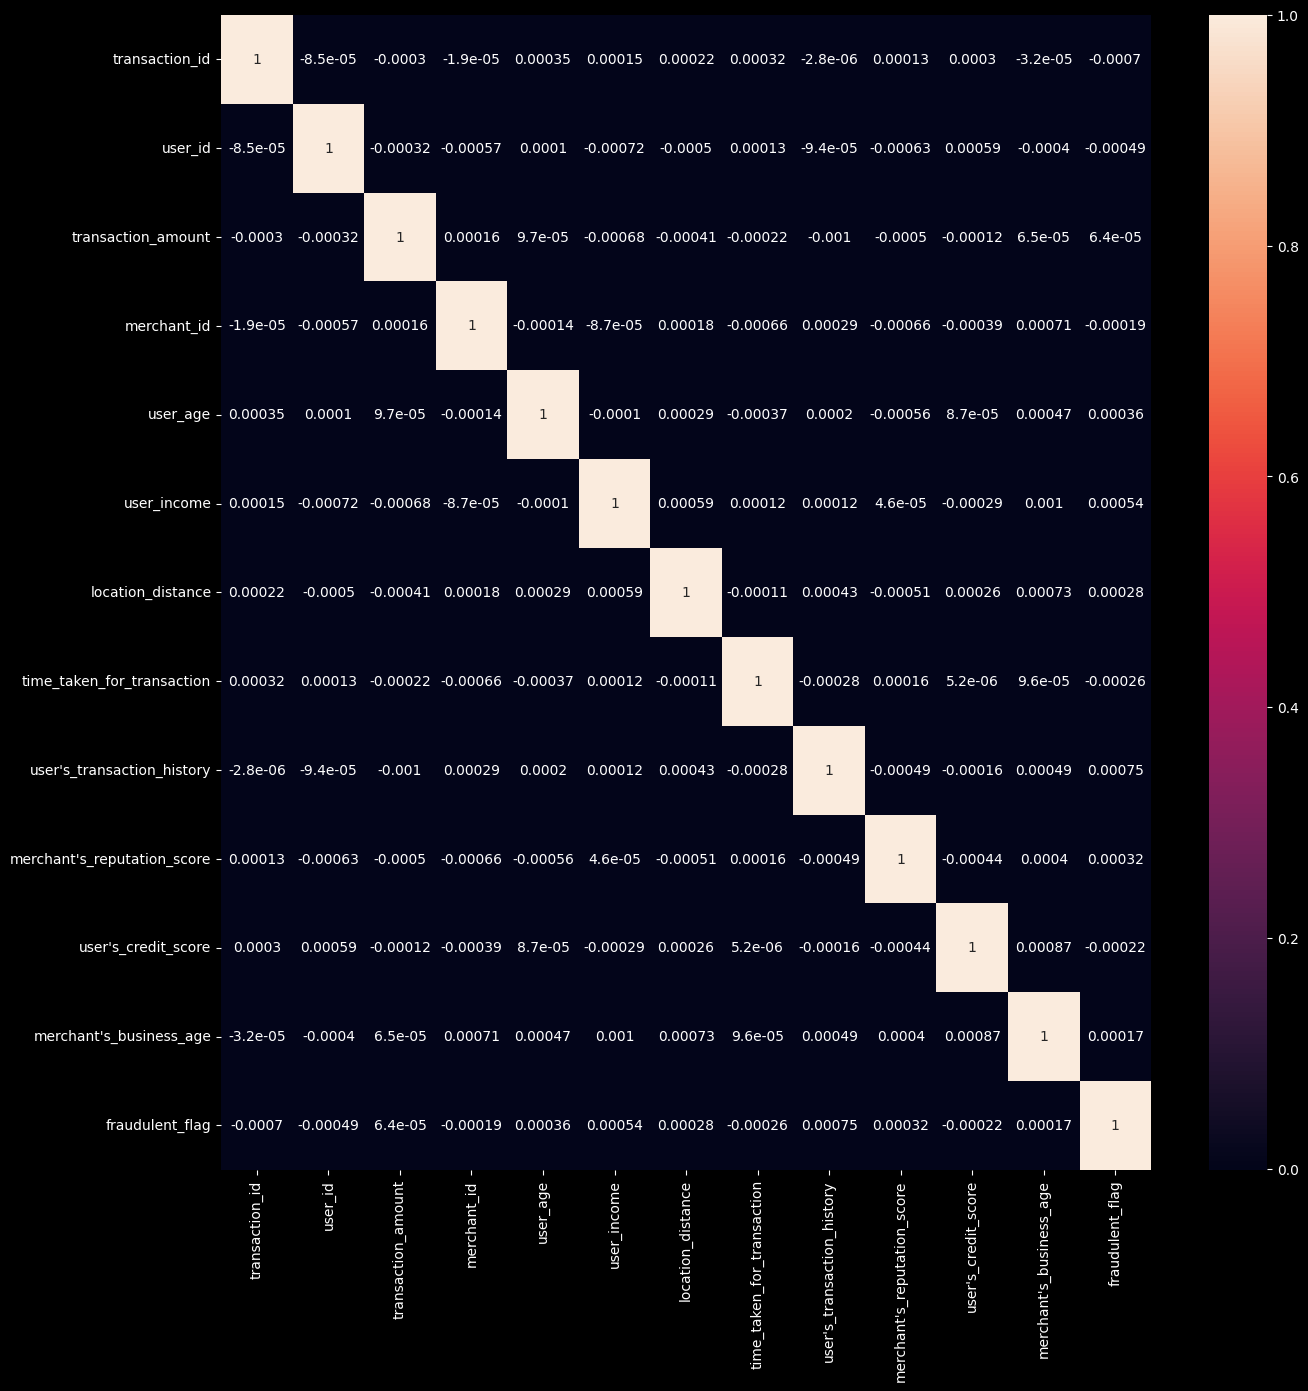

In [93]:
# creating a heatmap of the correlation

plt.figure(figsize=(15, 15))
sns.heatmap(fraud_df[corr_features].corr(),
            annot=True)

In [5]:
# formatting the column names to be more consistent
fraud_df.columns = fraud_df.columns.str.lower()
fraud_df.columns = fraud_df.columns.str.replace(" ", "_")

### Feature Engineering

In [6]:
# for feature in features:
#     score = mutual_info_score(fraud_df[feature], y)
#     print(f"{feature} score: {score}")


In [57]:
selected_features = ["user_income", "transaction_amount", "device_type", "payment_method",
                     "location_distance", "time_taken_for_transaction",
                     "user's_credit_score", "merchant_category", "merchant's_reputation_score",
                     "transaction_time_of_day", "transaction_authentication_method", 'user\'s_transaction_history',
                     'user_account_status', 'user_age', 'transaction_currency']

display(fraud_df[selected_features].head())

# seperating the data into target (y) and predictor (x) variables.
y = fraud_df["fraudulent_flag"]
X = fraud_df[selected_features]

,user_income,transaction_amount,device_type,payment_method,location_distance,time_taken_for_transaction,user's_credit_score,merchant_category,merchant's_reputation_score,transaction_time_of_day,transaction_authentication_method,user's_transaction_history,user_account_status,user_age,transaction_currency
0,66826.21,163.08,GPS Device,ACH Transfer,9.34,24.22,343,Industrial & Scientific,2.71,Daytime,Bluetooth Authentication,26,Pro,68,NOK
1,89356.71,430.74,Medical Device,2Checkout,65.28,55.11,688,Beauty & Cosmetics,3.95,Daytime,NFC Tag,60,Pending Approval,22,EGP
2,58438.63,415.74,Vehicle Infotainment System,Google Wallet,44.05,53.84,371,Real Estate,3.81,Daytime,Token,81,Pro,71,MXN
3,3426.92,565.89,Kiosk,Check,21.70,21.62,687,Appliances,2.67,Daytime,Time-Based OTP,18,Premium,78,CLP
4,53080.12,955.49,Smart Mirror,Worldpay,56.63,53.71,605,Jewelry,3.19,Daytime,Password,98,Free,31,RUB


### Encoding categorical variables

In [58]:
encoder = LabelEncoder()
merchant = encoder.fit_transform(fraud_df["merchant_category"])
time = encoder.fit_transform(fraud_df["transaction_time_of_day"])
auth = encoder.fit_transform(fraud_df["transaction_authentication_method"])
account_status = encoder.fit_transform(fraud_df["user_account_status"])
currency = encoder.fit_transform(fraud_df["transaction_currency"])
device = encoder.fit_transform(fraud_df["device_type"])
payment = encoder.fit_transform(fraud_df["payment_method"])

In [59]:
merchant = pd.DataFrame(merchant)
time = pd.DataFrame(time)
auth = pd.DataFrame(auth)
account_status = pd.DataFrame(account_status)
currency = pd.DataFrame(currency)
device = pd.DataFrame(device)
payment = pd.DataFrame(payment)

cat_col = pd.concat([merchant, time, auth, account_status, currency,
                     device, payment], axis=1)

cat_col= pd.concat([cat_col.iloc[:, 0].rename("merchant", inplace=True), 
           cat_col.iloc[:, 1].rename("time", inplace=True),
           cat_col.iloc[:, 2].rename("auth", inplace=True),
           cat_col.iloc[:, 3].rename("account_status", inplace=True),
           cat_col.iloc[:, 4].rename("currency", inplace=True),
           cat_col.iloc[:, 5].rename("device", inplace=True),
           cat_col.iloc[:, 6].rename("payment", inplace=True)], axis=1)



### Feature scaling

In [60]:
# dropping the categorical variables
print(X.dtypes)

X = X.drop(["merchant_category",
        "transaction_time_of_day",
        "transaction_authentication_method",
        'user\'s_transaction_history',
        'user_account_status',
        'transaction_currency',
        "device_type",
        "payment_method"], axis=1)

user_income                          float64
transaction_amount                   float64
device_type                           object
payment_method                        object
location_distance                    float64
time_taken_for_transaction           float64
user's_credit_score                    int64
merchant_category                     object
merchant's_reputation_score          float64
transaction_time_of_day               object
transaction_authentication_method     object
user's_transaction_history             int64
user_account_status                   object
user_age                               int64
transaction_currency                  object
dtype: object


In [61]:
# adding the encoded variables
X = pd.concat([X, cat_col], axis=1)
X.head()

,user_income,transaction_amount,location_distance,time_taken_for_transaction,user's_credit_score,merchant's_reputation_score,user_age,merchant,time,auth,account_status,currency,device,payment
0,66826.21,163.08,9.34,24.22,343,2.71,68,22,0,5,11,24,10,1
1,89356.71,430.74,65.28,55.11,688,3.95,22,4,0,18,9,11,18,0
2,58438.63,415.74,44.05,53.84,371,3.81,71,29,0,33,11,22,34,20
3,3426.92,565.89,21.70,21.62,687,2.67,78,0,0,32,10,6,16,10
4,53080.12,955.49,56.63,53.71,605,3.19,31,23,0,21,3,31,27,39


In [62]:
# using standard scaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)

In [63]:
scaled_df

array([[0.66491114, 0.16224224, 0.08424242, ..., 0.61538462, 0.27027027,
        0.02564103],
       [0.892492  , 0.43017017, 0.64929293, ..., 0.28205128, 0.48648649,
        0.        ],
       [0.5801881 , 0.41515516, 0.43484848, ..., 0.56410256, 0.91891892,
        0.51282051],
       ...,
       [0.32608421, 0.19647648, 0.91090909, ..., 0.35897436, 0.05405405,
        0.05128205],
       [0.05955668, 0.35768769, 0.9020202 , ..., 0.        , 0.56756757,
        0.53846154],
       [0.397202  , 0.65474474, 0.53454545, ..., 0.61538462, 0.64864865,
        0.74358974]])

#### Splitting the dataset into train and test

In [64]:
X_train, X_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.3)

In [65]:
# X_train.reset_index(drop=True, inplace=True)

In [66]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
# X_train.head()

(4200000, 14)
(1800000, 14)
(4200000,)
(1800000,)


### Model selection and fitting

In [67]:
# creating a parameter grid for Gridsearch

params = {
    "n_estimators": [1, 2, 3],
    "max_depth": [3, 4, 5],
    "learning_rate": [1, 1.5]
}

In [68]:
# using GridSearchCV
XGmodel = XGBClassifier(objective='binary:logistic')

randomized_search = RandomizedSearchCV(estimator=XGmodel, param_distributions=params, cv=3,
                           verbose=2)

randomized_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....learning_rate=1.5, max_depth=5, n_estimators=2; total time=  25.8s
[CV] END .....learning_rate=1.5, max_depth=5, n_estimators=2; total time=  18.6s
[CV] END .....learning_rate=1.5, max_depth=5, n_estimators=2; total time=  11.8s
[CV] END .......learning_rate=1, max_depth=5, n_estimators=3; total time=  13.2s
[CV] END .......learning_rate=1, max_depth=5, n_estimators=3; total time=  19.1s
[CV] END .......learning_rate=1, max_depth=5, n_estimators=3; total time=  17.8s
[CV] END .....learning_rate=1.5, max_depth=4, n_estimators=1; total time=  15.1s
[CV] END .....learning_rate=1.5, max_depth=4, n_estimators=1; total time=  14.4s
[CV] END .....learning_rate=1.5, max_depth=4, n_estimators=1; total time=  13.6s
[CV] END .......learning_rate=1, max_depth=3, n_estimators=1; total time=  18.1s
[CV] END .......learning_rate=1, max_depth=3, n_estimators=1; total time=  15.5s
[CV] END .......learning_rate=1, max_depth=3, n_

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_threshold=None,
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'learning_rate': [1, 1.5],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [1, 2, 3]},
                   verbose=2)

In [69]:
cv_results = randomized_search.cv_results_
cv_results['params']
cv_results['mean_test_score']

array([0.50036857, 0.49996548, 0.49970119, 0.49983714, 0.50005357,
       0.49983714, 0.49970119, 0.49998262, 0.49998262, 0.5004919 ])

In [73]:
XGmodel = XGBClassifier(
    n_estimators=4,
    max_depth=3,
    learning_rate=1,
    objective="binary:logistic"
)

XGmodel.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [94]:
y_pred = XGmodel.predict(X_test)

accuracy_score(y_pred, y_test)

0.5002672222222222

In [95]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.49      0.50      0.50    889232
           1       0.51      0.50      0.50    910768

    accuracy                           0.50   1800000
   macro avg       0.50      0.50      0.50   1800000
weighted avg       0.50      0.50      0.50   1800000

